## Anomaly Detection with Rolling Z-Score (Time Series Data)

#### Objective
Develop a robust anomaly detection system that:
1. Identifies unexpected spikes/drops in time series data
2. Learns normal patterns from historical trends
3. Provides visual and statistical evidence for anomalies
4. Validates new data points against learned patterns

#### Business Use cases
1. **Financial Monitoring**: Detect unusual transactions or revenue fluctuations
2. **IT Operations**: Identify abnormal server metrics or traffic patterns  
3. **Manufacturing**: Spot defects in production line sensor data
4. **Inventory Management**: Catch unexpected changes in stock levels

#### Implementation Details/Flow
1. **Data Load and cleanup**
2. **Baseline Calculation**: Compute 7-day rolling mean/std with 5-period warmup, Fallback to expanding stats for initial periods
3. **Anomaly Scoring**: 
    - Calculate Z-scores: (current - mean) / std
    - Flag points where |Z-score| > 2.5
4. **Trend Validation**:
    - Compare with prior window's slope
    - Confirm anomalies break established patterns
5. **Visualization**: Generate time series plot with anomalies highlighted
6. **New Data Evaluation**: Recalculate window stats, Compute Z-score, Return boolean flag

## 1. Import Libraries

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uuid
from IPython.display import display

## 2. Load Data

In [2]:
def load_data(file_path: str) -> pd.DataFrame:
    """Load and format CSV data."""
    df = pd.read_csv(file_path)
    df['business_date'] = pd.to_datetime(df['business_date'], format='%Y%m%d')
    return df

In [3]:
# Load sample data
print("Loading data...")
df = load_data('trends.csv')
display(df.head(3))

Loading data...


,business_date,row_op
0,2025-01-01,100.496714
1,2025-01-02,101.148408
2,2025-01-03,101.800103


## 3. Detect Anomalies Function

In [4]:
def detect_anomalies(df: pd.DataFrame, window: int = 10, threshold: float = 1.5) -> pd.DataFrame:
    """Detect anomalies using Z-score on rolling window."""
    if df.empty:
        raise ValueError("Dataframe is empty")
        
    # Calculate rolling statistics
    df['rolling_mean'] = df['row_op'].rolling(window=window, min_periods=1).mean()
    df['rolling_std'] = df['row_op'].rolling(window=window, min_periods=1).std()
    df['rolling_std'] = df['rolling_std'].fillna(1.0)
    
    # Calculate Z-scores
    df['z_score'] = (df['row_op'] - df['rolling_mean']) / df['rolling_std']
    df['is_anomaly'] = df['z_score'].abs() > threshold
    
    # Show diagnostic info
    print(f"Max Z-score: {df['z_score'].abs().max():.2f}")
    print("\nTop 3 potential outliers:")
    display(df[['business_date', 'row_op', 'z_score']].nlargest(3, 'z_score', keep='all'))
    
    return df

In [5]:
df = detect_anomalies(df)
display(df[df['is_anomaly']][['business_date', 'row_op', 'z_score']].head())

Max Z-score: 2.85

Top 3 potential outliers:


,business_date,row_op,z_score
9,2025-01-14,300.00000,2.845011
92,2025-05-09,180.00000,2.780993
19,2025-01-28,111.87891,1.486301


,business_date,row_op,z_score
9,2025-01-14,300.0,2.845011
52,2025-03-14,100.0,-2.802669
92,2025-05-09,180.0,2.780993


Output shows max Z-score, top outliers, and detected anomalies

## 4. Check New Value Anomaly Function

In [6]:
def check_new_value_anomaly(new_value: float, recent_data: pd.DataFrame,
                          window: int = 10, threshold: float = 1.5) -> bool:
    """Check if new value is an anomaly based on recent trends."""
    if len(recent_data) < window:
        return False
        
    recent = recent_data[-window:][['row_op']]
    rolling_mean = recent['row_op'].mean()
    rolling_std = recent['row_op'].std() or 1.0
    z_score = abs((new_value - rolling_mean) / rolling_std)
    
    print(f"New value: {new_value}")
    print(f"Recent mean: {rolling_mean:.2f}, std: {rolling_std:.2f}")
    print(f"Z-score: {z_score:.2f}")
    
    return z_score > threshold

In [7]:
# Test new value
test_value = 350
print("\nTesting new value...")
is_anomaly = check_new_value_anomaly(test_value, df)
print(f"\nIs anomaly? {'Yes' if is_anomaly else 'No'}")


Testing new value...
New value: 350
Recent mean: 160.92, std: 6.91
Z-score: 27.36

Is anomaly? Yes


Anomaly of new value has been detected correctly.

## 5. Result Visualization

In [8]:
def plot_anomalies(df: pd.DataFrame):
    """Plot row count trend with anomalies."""
    plt.figure(figsize=(12, 6))
    plt.plot(df['business_date'], df['row_op'], label='Normal')
    plt.scatter(df[df['is_anomaly']]['business_date'], 
               df[df['is_anomaly']]['row_op'],
               color='red', label='Anomalies', marker='x', s=100)
    
    plt.title('Time Series with Anomalies', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Row Output', fontsize=12)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


Generating visualization...


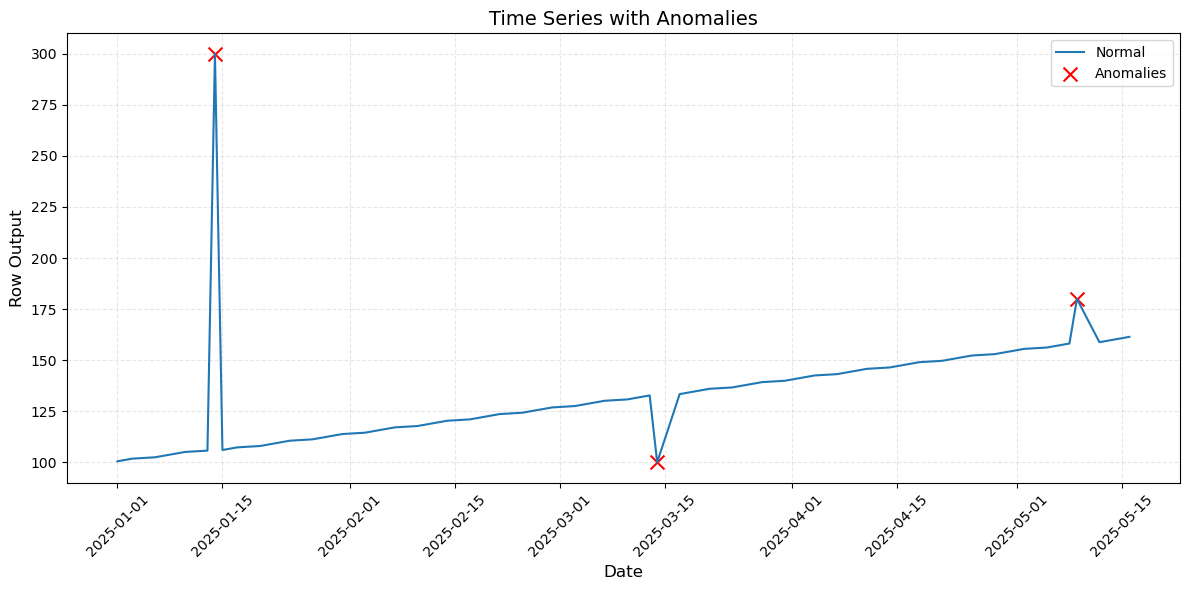

In [9]:
# Visualize results
print("\nGenerating visualization...")
plot_anomalies(df)